# LiFT tests

- This notebook was made having in base the python script kECK_LiFT.py

In [1]:
##%%
%reload_ext autoreload
%autoreload 2
# Commom modules
import matplotlib.pyplot as plt
import numpy as np

try:
    import cupy as cp
except ImportError or ModuleNotFoundError:
    print('CuPy is not found, using NumPy backend...')
    cp = np

from astropy.io import fits
from skimage.transform import resize
import skimage.measure
from tqdm import tqdm

# Local modules
from modules.Telescope import Telescope
from modules.Detector  import Detector
from modules.Source    import Source
from modules.Zernike   import Zernike
from modules.LIFT      import LIFT

# Local auxillary modules
from tools.misc import draw_PSF_difference
from tools.misc import mask_circle

CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...
CuPy is not found, using NumPy backend...


In [2]:
def make_3_plot_graph(data_1,title_1,data_2,title_2,data_3,title_3):

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Adjust the figure size as needed
    plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal spacing between subplots
    
    # Plot on each subplot
    img0 = axs[0].imshow(data_1)
    axs[0].set_title(title_1)
    fig.colorbar(img0, ax=axs[0])
    
    img1 = axs[1].imshow(data_2)
    axs[1].set_title(title_2)
    fig.colorbar(img1, ax=axs[1])
    
    img2 = axs[2].imshow(data_3)
    axs[2].set_title(title_3)
    fig.colorbar(img2, ax=axs[2])
    plt.show()

## Create circular telescope pupil

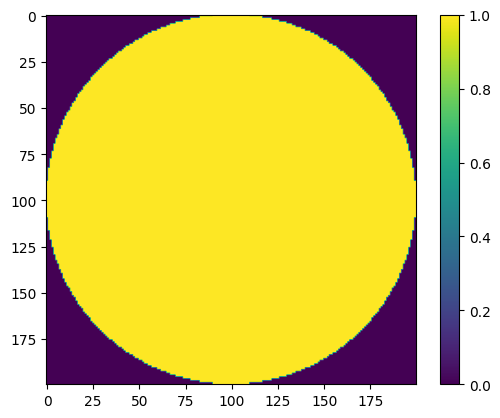

In [3]:
pupil_test = mask_circle(200, 100, center=(0,0), centered=True)

# mask_circle(N, r, center=(0,0), centered=True)
# creates a circular pupil mask
# N represents the number of pixels for both the x and y directions
# r represents the radius of the circular pupil in pixels

plt.imshow(pupil_test)
plt.colorbar()
plt.show()

17.058099515673703
217.65417170495772
-------------------- TELESCOPE --------------------
Diameter 			10.0 	 [m]
Pupil sampling 			200 	 [pix]
------------------------------------------------
Telescope's pupil area = 78.53981633974483 [m^2]
Source spectrum
[{'wavelength': 1.654e-06, 'bandwidth': 2.9e-07, 'flux': 298913.04347826086}]
[{'wavelength': 1.654e-06, 'bandwidth': 2.9e-07, 'flux': 298913.04347826086}]
(200, 200)


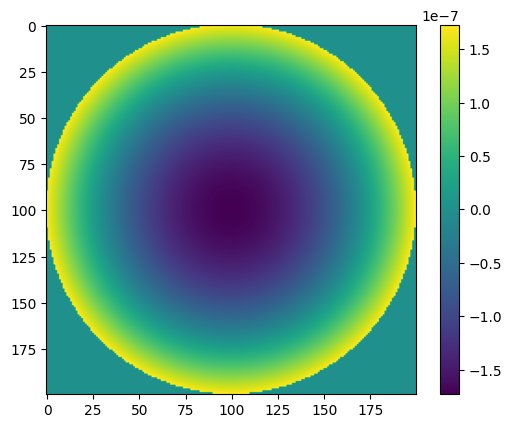

In [4]:
D = 10.0 # [m]
resolution = 200 # telescope resolution (pupil sampling)

ang_pixel_Nyquist_rad = 0.5*(1.654e-06)/D

pixel_size = 18e-6 # [m]
ang_pixel = ang_pixel_Nyquist_rad*206264806.71915 # [mas]
print(ang_pixel)
f = pixel_size / ang_pixel * 206264806.71915 # [m]
print(f)

# Let's imagine we have DITs (detector integration times) of 10 frames with a total of 1 second exposure
# This is to generate a synthetic PSF 
sampling_time = 0.1 # [s]
num_samples = 10

# If the number of pixels in image is odd, the code will automatically center generated PSFs it to one pixel in the middle
tel = Telescope(img_resolution        = 50,  # img_resolution - Sampling of the telescope's PSF
                    pupil             = mask_circle(resolution, resolution/2, center=(0,0), centered=True),
                    diameter          = D,
                    focalLength       = f,
                    pupilReflectivity = 1.0,
                    gpu_flag          = False)


print("Telescope's pupil area = {} [m^2]".format(tel.area))

det = Detector(pixel_size     = pixel_size,
                sampling_time = sampling_time,
                samples       = num_samples,
                RON           = 5.0, # used to generate PSF or the synthetic R_n [photons]
                QE            = 0.7) # not used

det.object = None
det * tel
ngs = Source([('H', 10.0)]) # Initialize a target of H_mag=10
ngs * tel # attach the source to the telescope

print('Source spectrum')
print(ngs.spectrum)
print(tel.src.spectrum)

# Initialize modal basis
Z_basis = Zernike(modes_num = 10)
Z_basis.computeZernike(tel)

# Generate OPD according to certain zernike modes
coefs = np.zeros(10)
coefs[2] = 100*1e-9 # [m]

tel.src.OPD = Z_basis.wavefrontFromModes(tel,coefs)

print(tel.src.OPD.shape)

plt.imshow(tel.src.OPD)
plt.colorbar()
plt.show()

CuPy is not found, using NumPy backend...


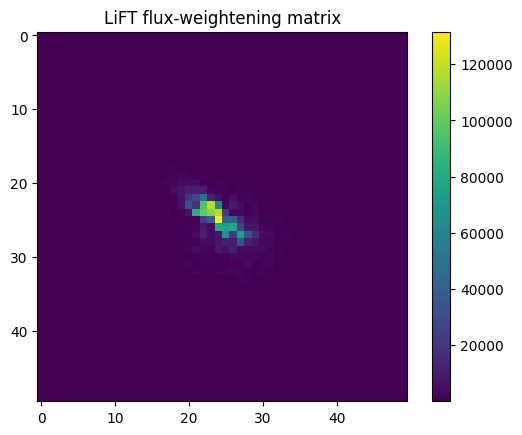

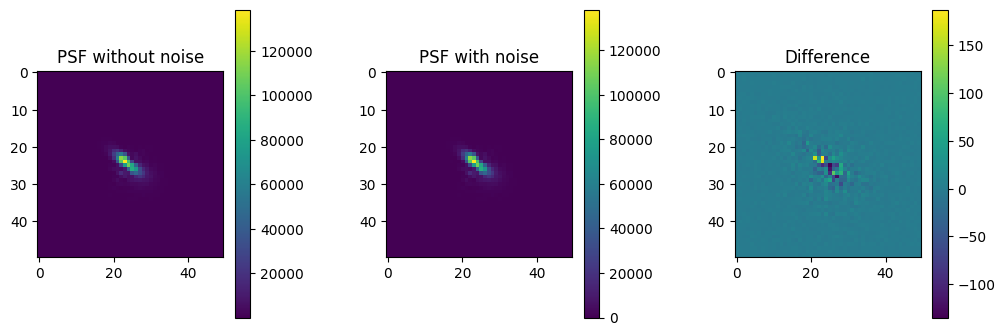

[ 1.0245769e-08 -1.4984529e-07  1.9994415e-07  2.0166551e-08
 -4.4930765e-08  3.4019997e-08  5.0976595e-08 -2.8936245e-08
  2.0151557e-08  1.0033179e-08]


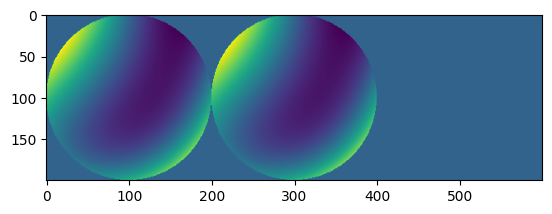

WFE:  0 [nm]


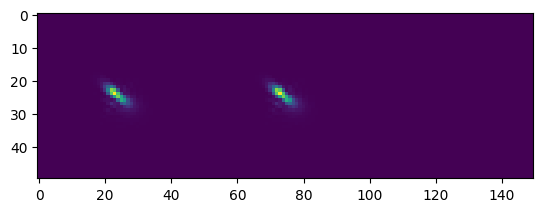

Coefficients difference [nm]:  0 0 0 0 0 0 0 0 0 0


In [6]:
diversity_shift = 200e-9 #[m]
OPD_diversity = Z_basis.Mode(3)*diversity_shift

##%%  ============================ Code in this cell is NOT must have ============================
# Synthetic PSF
coefs_0 = np.array([10, -150, 200, 20, -45, 34, 51, -29, 20, 10])*1e-9 # [m]

def PSFfromCoefs(coefs):
    tel.src.OPD = Z_basis.wavefrontFromModes(tel,coefs) + OPD_diversity
    PSF = tel.ComputePSF()
    tel.src.OPD *= 0.0 # zero out just in case
    return PSF

PSF = PSFfromCoefs(coefs_0)
PSF_noisy_DITs, _ = tel.det.getFrame(PSF, noise=True, integrate=False)

R_n = PSF_noisy_DITs.var(axis=2)    # LIFT flux-weighting matrix
PSF_0 = PSF_noisy_DITs.mean(axis=2) # input PSF

plt.imshow(R_n)
plt.title("LiFT flux-weightening matrix")
plt.colorbar()
plt.show()

make_3_plot_graph(PSF,"PSF without noise",PSF_0,"PSF with noise",PSF-PSF_0,"Difference")

##%%  ============================ Code in this cell is must have ============================
estimator = LIFT(tel, Z_basis, OPD_diversity, 20)

# Increase the flux artificially to test the robustness of the normalization
# optimization inside the LIFT
PSF_0 *= 4
R_n *= 4

modes = [0,1,2,3,4,5,6,7,8,9]
#                                           Flux optimization is important! --------------V
coefs_1, PSF_1, _ = estimator.Reconstruct(PSF_0, R_n='model', mode_ids=modes, optimize_norm='sum')

print(coefs_1)

#%  ============================ Code in this cell is NOT must have ============================
def GenerateWFE(coefs):
    return (Z_basis.wavefrontFromModes(tel,coefs[modes]) + OPD_diversity)*1e9 # [m]

WF_0 = GenerateWFE(coefs_0)
WF_1 = GenerateWFE(coefs_1)

to_show_WF = np.hstack([WF_0, WF_1, np.abs(WF_0-WF_1)])

if hasattr(to_show_WF, 'device'): to_show_WF = cp.asnumpy(to_show_WF)
plt.imshow(to_show_WF)
plt.show()

print('WFE: ', np.round(np.std(WF_0-WF_1)).astype('int'), '[nm]')

#plt.imshow(np.hstack([np.log(PSF_0), np.log(PSF_1), np.log(np.abs(PSF_0-PSF_1))]))

to_show_PSF = np.hstack([PSF_0, PSF_1, np.abs(PSF_0-PSF_1)])
if hasattr(to_show_PSF, 'device'): to_show_PSF = cp.asnum(to_show_PSF)

plt.imshow(to_show_PSF)
plt.show()

print('Coefficients difference [nm]: ', *np.round((coefs_0[modes]-coefs_1[modes])*1e9).astype('int').tolist() )

100%|██████████| 81/81 [06:32<00:00,  4.85s/it]


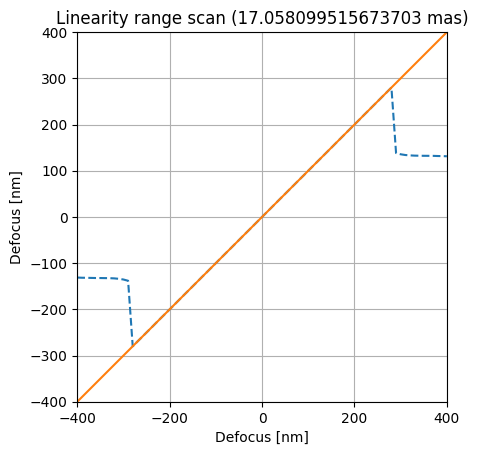

In [7]:
##%% ------- Linearity range scanning -------
def_scan = np.arange(-400,401,10)*1e-9
modes = [0,1,2,3,4]

defocus_est = []

for defocus in tqdm(def_scan):  # tqdm - shows progress bar
    coefs_def = np.zeros(10)
    coefs_def[2] = defocus

    PSF = PSFfromCoefs(coefs_def)
    PSF_noisy_DITs, _ = tel.det.getFrame(PSF, noise=True, integrate=False)
    R_n = PSF_noisy_DITs.var(axis=2) 
    PSF_0 = PSF_noisy_DITs.mean(axis=2)

    coefs_1, PSF_1, _ = estimator.Reconstruct(PSF_0, R_n='model', mode_ids=modes, optimize_norm=None)
    defocus_est.append(coefs_1[2])

defocus_est = np.array(defocus_est)
ax = plt.gca() #you first need to get the axis handle
ax.set_aspect(1)
plt.plot(def_scan*1e9, defocus_est*1e9,"--")
plt.plot(np.array([def_scan.min()*1e9, def_scan.max()*1e9]), np.array([def_scan.min()*1e9, def_scan.max()*1e9]))
plt.grid()
plt.xlim([def_scan.min()*1e9, def_scan.max()*1e9])
plt.ylim([def_scan.min()*1e9, def_scan.max()*1e9])
plt.xlabel('Defocus [nm]')
plt.ylabel('Defocus [nm]')
plt.title('Linearity range scan ('+str(ang_pixel)+' mas)')
plt.show()
# %%

In [ ]:
modes = [0,1,2,3,4,5,6,7,8,9]

for i in range(100):  # tqdm - shows progress bar
    
    coefs_def = np.random.uniform(-100, 100, 10)*1e-9

    PSF = PSFfromCoefs(coefs_def)
    PSF_noisy_DITs, _ = tel.det.getFrame(PSF, noise=True, integrate=False)
    R_n = PSF_noisy_DITs.var(axis=2) 
    PSF_0 = PSF_noisy_DITs.mean(axis=2)

    coefs_1, PSF_1, _ = estimator.Reconstruct(PSF_0, R_n='model', mode_ids=modes, optimize_norm=None)

    k = 2*np.pi/tel.src.spectrum[0]['wavelength']

    coefs_1_rad = coefs_1*k
    coefs_def_rad = coefs_def*k
    
    sigma_c = np.sqrt(np.sum((coefs_1_rad - coefs_def_rad)**2)/(10))

    plt.plot(np.arange(10),coefs_def_rad,"ko",label="Initial zernike amplitudes")
    plt.plot(np.arange(10),coefs_1_rad,"g.",label="Estimated zernike amplitudes")
    plt.title(r"RMSE ($\sigma_c$) = {}".format(sigma_c))
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
coefs_def = np.zeros(10)

log_f_values = np.arange(-2,0+0.6,0.2)
print(log_f_values)

f = 10**log_f_values
print(f)

modes = [0,1,2,3,4,5,6,7,8,9]

ast_diversity = [100, 200]

for ast in ast_diversity:

    OPD_diversity = Z_basis.Mode(3)*ast*1e-9

    estimator = LIFT(tel, Z_basis, OPD_diversity, 20)

    sigma_c_mean = []

    for f_value in f:
        print(f_value)
        
        delta_c = f_value*ast
        array_aux = np.zeros(25)
        
        for i in range(25):
            coefs_def = np.random.uniform(-delta_c, delta_c, 10)*1e-9
        
            PSF = PSFfromCoefs(coefs_def)
        
            coefs_1, PSF_1, _ = estimator.Reconstruct(PSF, R_n='model', mode_ids=modes, optimize_norm=None)
        
            k = 2*np.pi/tel.src.spectrum[0]['wavelength']
        
            coefs_1_rad = coefs_1*k
            coefs_def_rad = coefs_def*k
            
            sigma_c = np.sqrt(np.sum((coefs_1_rad - coefs_def_rad)**2)/(10))
    
            array_aux[i] = sigma_c
    
        sigma_c_mean.append(np.mean(array_aux))
    
    plt.plot(log_f_values,np.log10(np.array(sigma_c_mean)),"o-",label="Astigmatism = {} nm".format(ast))
    plt.xlabel("log(f)")
    plt.ylabel(r'$log(\sigma_c)$')
    plt.title("N= 10 modes; 1.0 Nyquist sampling; no noise",fontsize=14)
    plt.legend()
    plt.grid()

plt.grid()
plt.show()

In [12]:
print(tel.src.spectrum)
print(tel.src.spectrum[0]['wavelength']/10 * 206265000/50)
print(34/50*200)
print(np.ceil(2.0/0.1).astype('int'))

[{'wavelength': 1.654e-06, 'bandwidth': 2.9e-07, 'flux': 298913.04347826086}]
0.6823246199999999
136.0
20


In [13]:
np.ceil(2/0.68)

3.0